In [1]:
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing and clustering
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score

# For dimensionality reduction (visualization)
from sklearn.decomposition import PCA


In [16]:
# Convert date columns to datetime
customers_df['SignupDate'] = pd.to_datetime(customers_df['SignupDate'])
transactions_df['TransactionDate'] = pd.to_datetime(transactions_df['TransactionDate'])

# Create a reference date, for example the max of transaction date, to compute recency.
last_transaction_date = transactions_df['TransactionDate'].max()

# Aggregate transaction data by CustomerID
agg_trans = transactions_df.groupby('CustomerID').agg({
    'TransactionID': 'count',          # number of transactions
    'TotalValue': ['sum', 'mean'],     # total spend, average transaction value
    'Quantity': 'sum',                 # total quantity purchased
    'TransactionDate': 'max'           # most recent transaction date
})

agg_trans.columns = [
    'NumTransactions',
    'TotalSpend',
    'AvgTransactionValue',
    'TotalQuantity',
    'MostRecentTransactionDate'
]

agg_trans.reset_index(inplace=True)

# Calculate recency (days since last transaction)
agg_trans['RecencyDays'] = (last_transaction_date - agg_trans['MostRecentTransactionDate']).dt.days

# Merge with customer dataframe
cust_merged = pd.merge(customers_df, agg_trans, on='CustomerID', how='left')

# Time since signup (in days)
max_date = max(last_transaction_date, customers_df['SignupDate'].max())
cust_merged['DaysSinceSignup'] = (max_date - cust_merged['SignupDate']).dt.days

# Fill NaN values (if any customers have no transactions, they might have NaN)
cust_merged.fillna({
    'NumTransactions': 0,
    'TotalSpend': 0,
    'AvgTransactionValue': 0,
    'TotalQuantity': 0,
    'RecencyDays': (max_date - cust_merged['SignupDate']).dt.days  # or some default
}, inplace=True)

# Check the merged data
print(cust_merged.head())


  CustomerID        CustomerName         Region SignupDate  NumTransactions  \
0      C0001    Lawrence Carroll  South America 2022-07-10              5.0   
1      C0002      Elizabeth Lutz           Asia 2022-02-13              4.0   
2      C0003      Michael Rivera  South America 2024-03-07              4.0   
3      C0004  Kathleen Rodriguez  South America 2022-10-09              8.0   
4      C0005         Laura Weber           Asia 2022-08-15              3.0   

   TotalSpend  AvgTransactionValue  TotalQuantity MostRecentTransactionDate  \
0     3354.52              670.904           12.0       2024-11-02 17:04:16   
1     1862.74              465.685           10.0       2024-12-03 01:41:41   
2     2725.38              681.345           14.0       2024-08-24 18:54:04   
3     5354.88              669.360           23.0       2024-12-23 14:13:52   
4     2034.24              678.080            7.0       2024-11-04 00:30:22   

   RecencyDays  DaysSinceSignup  
0         55.0  

In [18]:
feature_cols = [
    'NumTransactions',
    'TotalSpend',
    'AvgTransactionValue',
    'TotalQuantity',
    'RecencyDays',
    'DaysSinceSignup'
    # plus any Region_... columns after one-hot encoding, e.g. 'Region_Asia', 'Region_Europe', etc.
]

# If you used get_dummies above, automatically add them:
region_cols = [col for col in cust_merged.columns if col.startswith('Region_')]
feature_cols.extend(region_cols)

X = cust_merged[feature_cols].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)



In [19]:
db_scores = []
models = []

K_range = range(2, 11)  # from 2 to 10 clusters
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    labels = kmeans.labels_

    # Compute DB index
    db_index = davies_bouldin_score(X_scaled, labels)
    db_scores.append(db_index)
    models.append(kmeans)

# Display results
for k, score in zip(K_range, db_scores):
    print(f"k = {k}, DB Index = {score:.4f}")

# Choose the best k based on the lowest DB Index
best_k = K_range[np.argmin(db_scores)]
print(f"\nBest k by Davies-Bouldin Index: {best_k}")


k = 2, DB Index = 1.3350
k = 3, DB Index = 1.1984
k = 4, DB Index = 1.3082
k = 5, DB Index = 1.2409
k = 6, DB Index = 1.2811
k = 7, DB Index = 1.2620
k = 8, DB Index = 1.2726
k = 9, DB Index = 1.1950
k = 10, DB Index = 1.2092

Best k by Davies-Bouldin Index: 9


In [20]:
best_model_index = np.argmin(db_scores)
best_model = models[best_model_index]
final_labels = best_model.labels_

# Add cluster labels back to the dataframe
cust_merged['Cluster'] = final_labels


In [8]:
# Retrieve the best model and its labels
best_model = models[best_k]
best_labels = best_model.labels_

# Add cluster labels back to the dataframe
customer_profile['Cluster'] = best_labels

# Display some rows with the assigned clusters
display(customer_profile.head(10))


,CustomerID,CustomerName,Region,SignupDate,TotalQuantity,TotalSpend,NumTransactions,AvgOrderValue,RegionEncoded,DaysSinceSignup,Cluster
0,C0001,Lawrence Carroll,South America,2022-07-10,12.0,3354.52,5.0,670.904000,3,932,5
1,C0002,Elizabeth Lutz,Asia,2022-02-13,10.0,1862.74,4.0,465.685000,0,1079,3
2,C0003,Michael Rivera,South America,2024-03-07,14.0,2725.38,4.0,681.345000,3,326,1
3,C0004,Kathleen Rodriguez,South America,2022-10-09,23.0,5354.88,8.0,669.360000,3,841,7
4,C0005,Laura Weber,Asia,2022-08-15,7.0,2034.24,3.0,678.080000,0,896,3
5,C0006,Brittany Palmer,South America,2024-01-07,12.0,4227.57,4.0,1056.892500,3,386,1
6,C0007,Paul Graves,Asia,2022-06-18,8.0,2579.82,3.0,859.940000,0,954,3
7,C0008,David Li,North America,2024-01-13,20.0,4271.61,10.0,427.161000,2,380,8
8,C0009,Joy Clark,Europe,2023-08-14,3.0,896.50,3.0,298.833333,1,532,2
9,C0010,Aaron Cox,Europe,2022-12-15,12.0,1717.55,4.0,429.387500,1,774,3


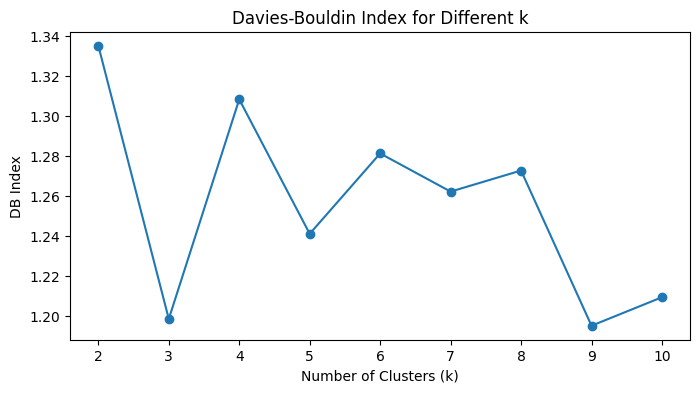

In [21]:
plt.figure(figsize=(8, 4))
plt.plot(K_range, db_scores, marker='o')
plt.title('Davies-Bouldin Index for Different k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('DB Index')
plt.xticks(K_range)
plt.show()


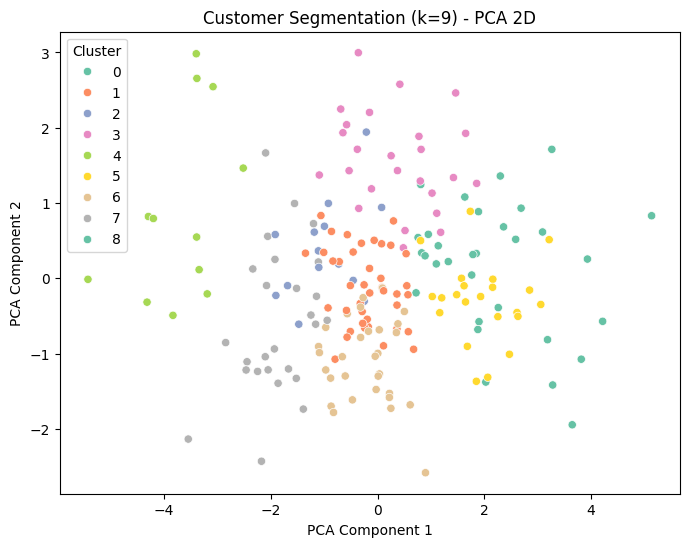

In [22]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=X_pca[:,0],
    y=X_pca[:,1],
    hue=final_labels,
    palette='Set2'
)

plt.title(f"Customer Segmentation (k={best_k}) - PCA 2D")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title='Cluster')
plt.show()


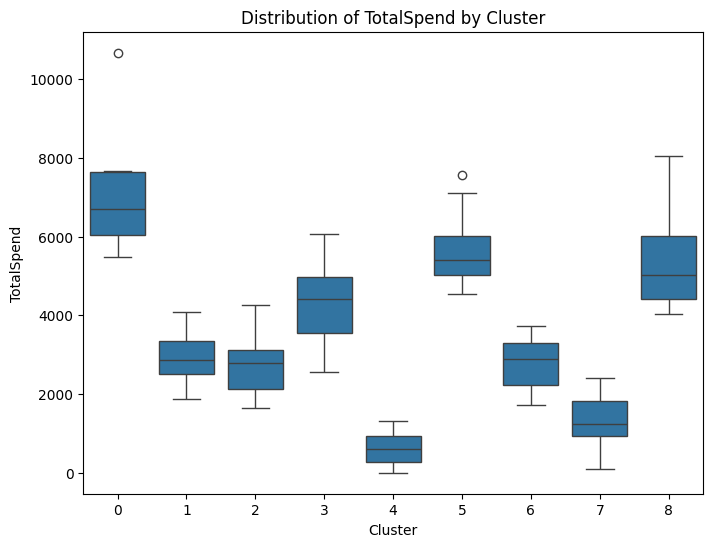

In [23]:
# Example box plot for TotalSpend by cluster
plt.figure(figsize=(8, 6))
sns.boxplot(x='Cluster', y='TotalSpend', data=cust_merged)
plt.title('Distribution of TotalSpend by Cluster')
plt.show()
